In [1]:
import sys
sys.path.append("..")

from newutils.pickleloader import load_pickle, dump_pickle
import newutils.preprocess as preprocess
import newutils.fdt as fdt
import newutils.mhue as mhue
import newutils.homogeneity as homogeneity
import newutils.stability as stability
import newutils.match_groundtruth as match_groundtruth
import newutils.region as region
import newutils.bound as bound

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from scipy.ndimage import distance_transform_cdt

import warnings
warnings.filterwarnings("ignore")

In [2]:
importlib.reload(bound)

<module 'newutils.bound' from '../newutils/bound.py'>

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [57]:
def pre_run(input_idx):
    result = {}
    path = '../image/ixi-N4corrected/'
    filenames = os.listdir(path)
    img_org_lst = [cv.imread(path+filename,0) for filename in filenames]
    pattern = r'([0-9]+)-'
    img_idx = [re.findall(pattern,filename)[0] for filename in filenames]
    if input_idx != None:
        tmp = [img_idx.index(i) for i in input_idx]
        img_org_lst = [img_org_lst[i] for i in tmp]
        img_idx = [img_idx[i] for i in tmp]
    
    
    img_lst = []
    scharr_lst = []
    img_bdts_o = []
    img_bdts_b = []
    stab_lst = []
    scharr_b_lst = []
    delta_lst = []
    for lst_idx, img in enumerate(img_org_lst):
        idx = img_idx[lst_idx]
        print("Index: {}, ".format(idx),end="")
        
        # Mask and crop
        print("Mask..",end="")
        img = preprocess.mask_image(img, beta=10)
        img_lst.append(img)
        
        # Grad
        print("Gradient Map..",end="")
        img_equalize = cv.fastNlMeansDenoising(img)
        img_equalize = cv.equalizeHist(img_equalize)
        scharr = homogeneity.get_scharr(img_equalize)
#         scharr = homogeneity.get_scharr(img)
        scharr = homogeneity.rank_normalize(scharr)
        scharr_lst.append(scharr)
        
        # BDT
        print("BDT..",end="")
        inten_min, inten_max = np.min(img), np.max(img)
        n_pixels = np.size(img)
        t1, t2 = inten_min + 2, inten_max - 2
        bdts_o = []
        bdts_b = []
        for t in range(t1, t2):
            # object
            _, src = cv.threshold(img, t, 255, cv.THRESH_BINARY)
            bdt_o = distance_transform_cdt(src,return_distances=True)
            bdts_o.append(bdt_o)
            # background
            src = 255-src
            bdt_b = distance_transform_cdt(src,return_distances=True)
            bdts_b.append(bdt_b)
        img_bdts_o.append(bdts_o)
        img_bdts_b.append(bdts_b)
        
        # Stability
        print("Stability..",end="")
        stab = stability.get_stability(img,bdts_o)
        stab_lst.append(stab)
        
        # Bounding Grad
        print("Bounded Gradient Map..")
        scharr_b, delta = bound.get_scharr_bounding(img, scharr, bdts_o, 60)
        scharr_b_lst.append(scharr_b)
        delta_lst.append(delta)
        
    result['img_org'] = img_org_lst
    result['img'] = img_lst
    result['scharr'] = scharr_lst
    result['bdts_o'] = img_bdts_o
    result['bdts_b'] = img_bdts_b
    result['stab'] = stab_lst
    result['scharr_b'] = scharr_b_lst
    result['delta'] = delta_lst
    return result

In [58]:
idx_lst = ['109','045','012','113','041','059','084','089','105','035']
param = pre_run(idx_lst)

Index: 109, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 045, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 012, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 113, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 041, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 059, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 084, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 089, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 105, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 035, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..


In [59]:
def MHUE(img_idx,param):
    img_lst = param['img']
    scharr_lst = param['scharr']
    
    uncertainty_lst = []
    mhue_lst = []
    mhue_t = []
    
    for idx,img in enumerate(img_lst):
        uncertainty = mhue.get_uncertainty(img)
        scharr = scharr_lst[idx]
        mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr)
        mhue_lst.append(mhue_img)
        mhue_img = list(map(lambda x:np.sum(x), mhue_img))
        mhue_mint = np.argmin(mhue_img) + np.min(img) + 2
        print('Index: {}, MHUE threshold at: {}.'.format(img_idx[idx], mhue_mint))
        mhue_t.append(mhue_mint)
        uncertainty_lst.append(uncertainty)
    
    param['uncertainty'] = uncertainty_lst
    param['mhue'] = mhue_lst
    param['mhue_t'] = mhue_t
    
    return param

In [60]:
param = MHUE(idx_lst, param)

Index: 109, MHUE threshold at: 123.
Index: 045, MHUE threshold at: 118.
Index: 012, MHUE threshold at: 111.
Index: 113, MHUE threshold at: 125.
Index: 041, MHUE threshold at: 122.
Index: 059, MHUE threshold at: 133.
Index: 084, MHUE threshold at: 123.
Index: 089, MHUE threshold at: 133.
Index: 105, MHUE threshold at: 151.
Index: 035, MHUE threshold at: 96.


In [61]:
# Region score: bounded gradient map & stability weighted uncertainty
def region_score(img_idx,param):
    img_lst = param['img']
    scharr_b_lst = param['scharr_b']
    stab_lst = param['stab']
    img_bdts_o = param['bdts_o']
    img_bdts_b = param['bdts_b']
    delta_lst = param['delta']
    
    regions = []
    r_recons = []
    region_t = []
    uncertaintyws = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                            bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=31,sigma=0.5)
        uncertaintyws.append(uncertaintyw)
        scharr = scharr_b_lst[idx]
        delta = delta_lst[idx]
        
        region_i = region.get_score(img,uncertaintyw,scharr,kernel_size=5,bounding=True)
        
        regions.append(region_i)
        r_recon = region.vmd_extract(region_i,var_min=0.01)
        r_recons.append(r_recon)
        best_region_t = argrelmax(r_recon,order=delta//2)[0] + np.min(img) + 2
        region_t.append(best_region_t)
        print('Index: {}, Region score possible threshold: {}.'.format(img_idx[idx], best_region_t))
    
    param['uncertaintyw'] = uncertaintyws
    param['region'] = regions
    param['r_recon'] = r_recons
    param['region_t'] = region_t
    return param

In [62]:
param = region_score(idx_lst, param)

Index: 109, Region score possible threshold: [86].
Index: 045, Region score possible threshold: [92].
Index: 012, Region score possible threshold: [79].
Index: 113, Region score possible threshold: [96].
Index: 041, Region score possible threshold: [ 85 236].
Index: 059, Region score possible threshold: [101].
Index: 084, Region score possible threshold: [128].
Index: 089, Region score possible threshold: [ 99 130].
Index: 105, Region score possible threshold: [116].
Index: 035, Region score possible threshold: [ 72  98 119].


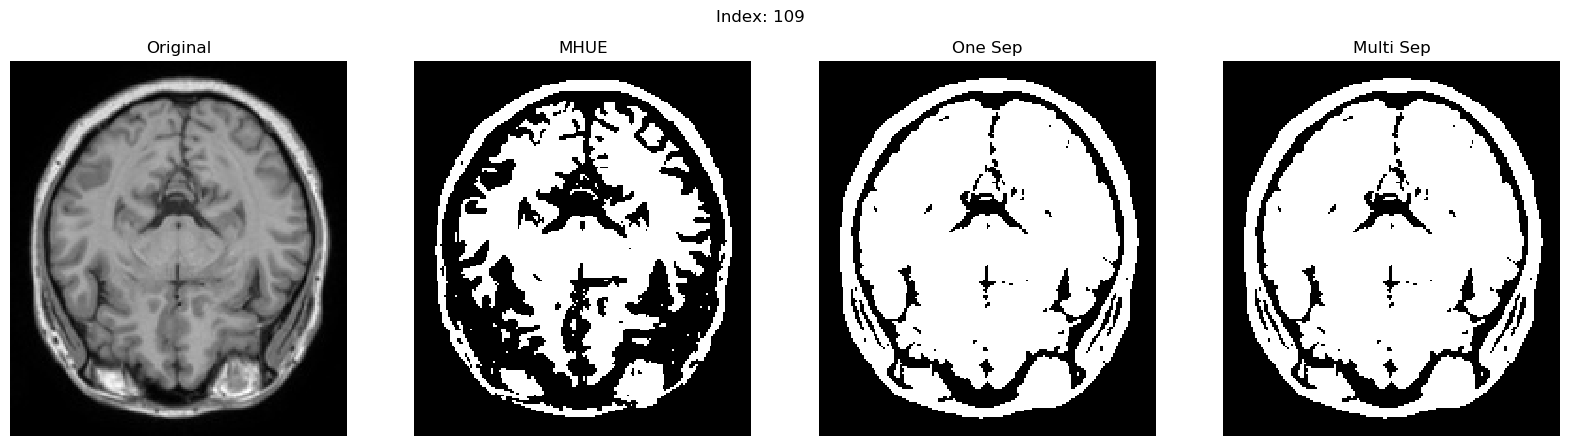

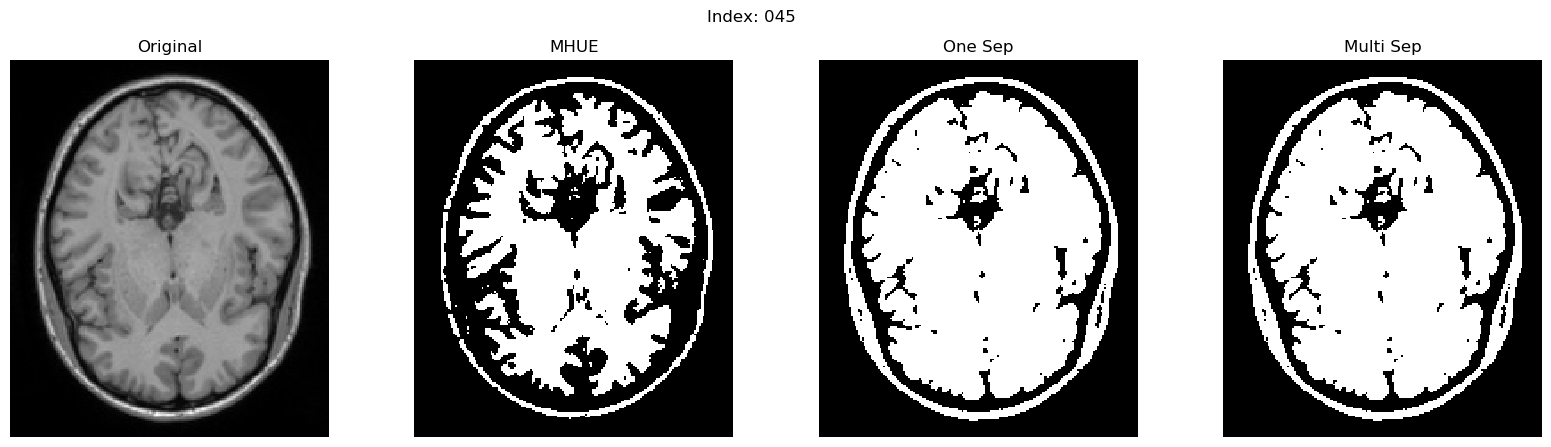

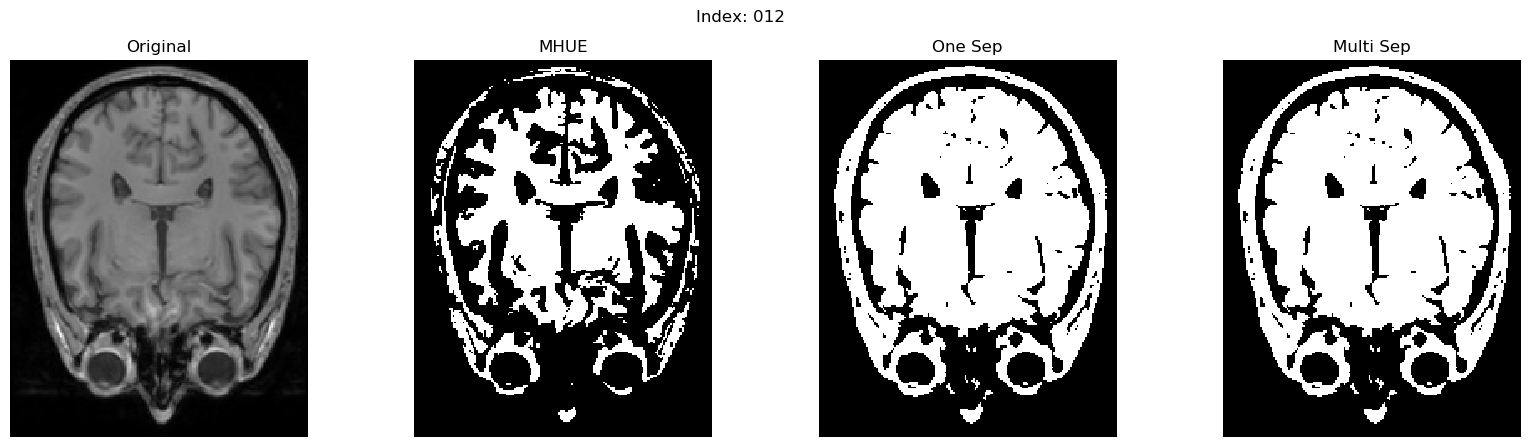

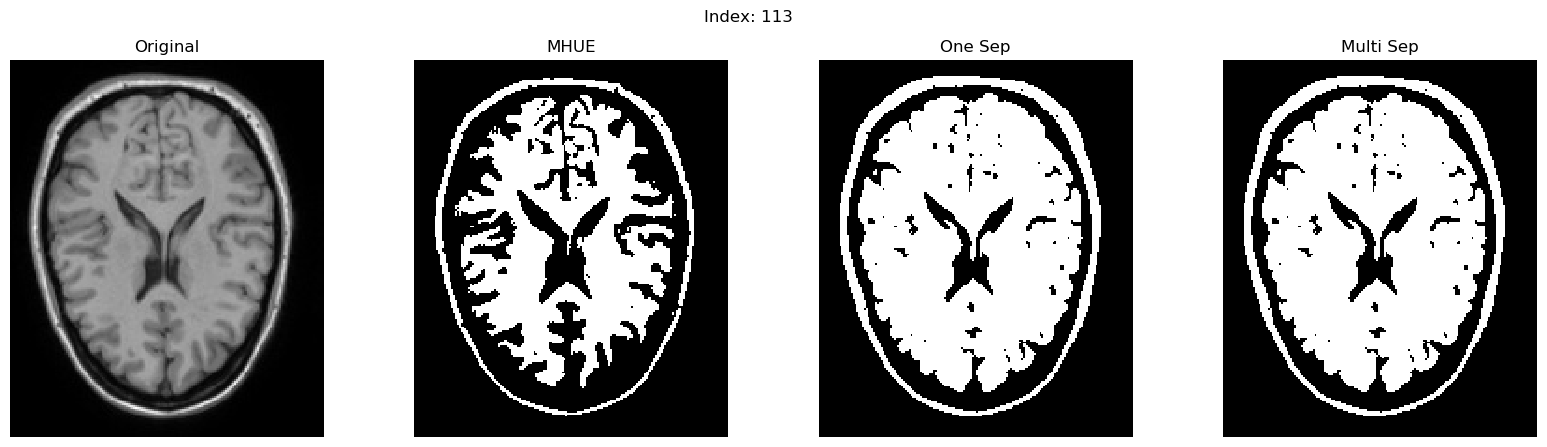

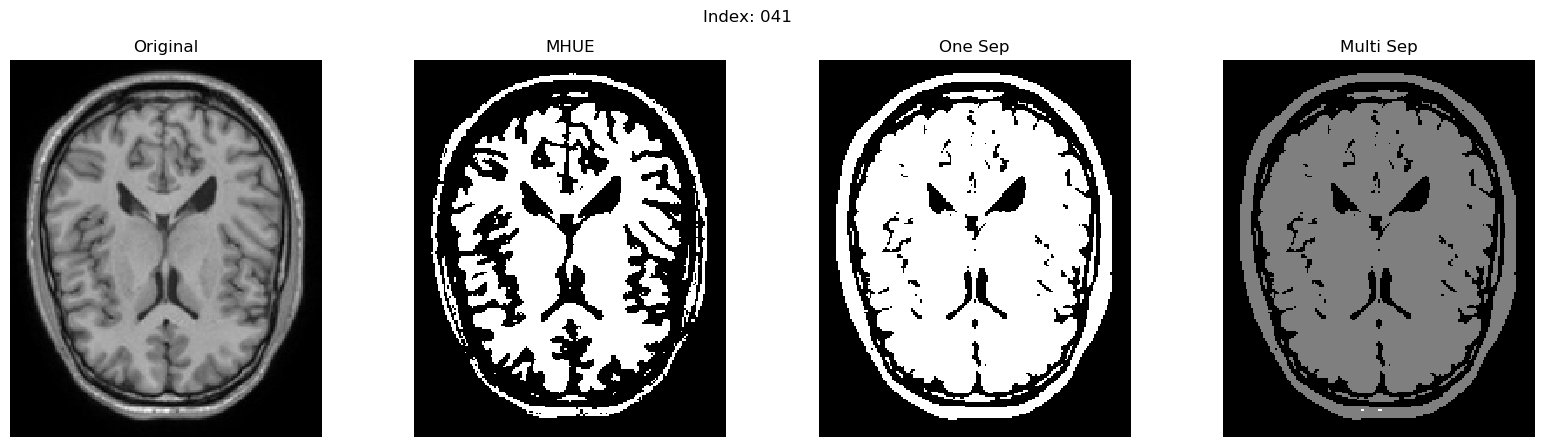

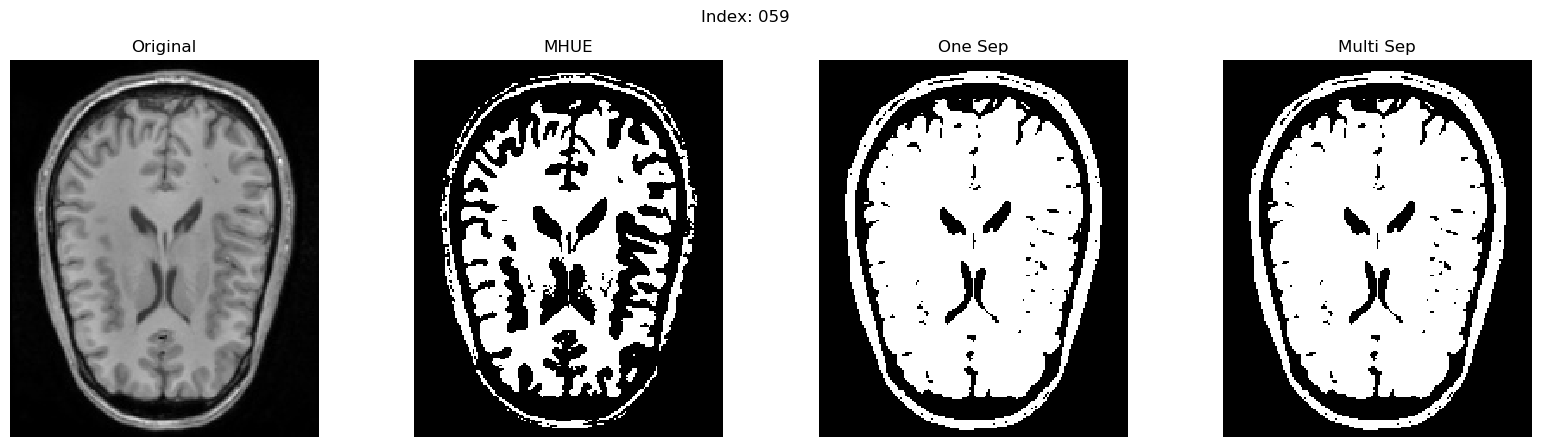

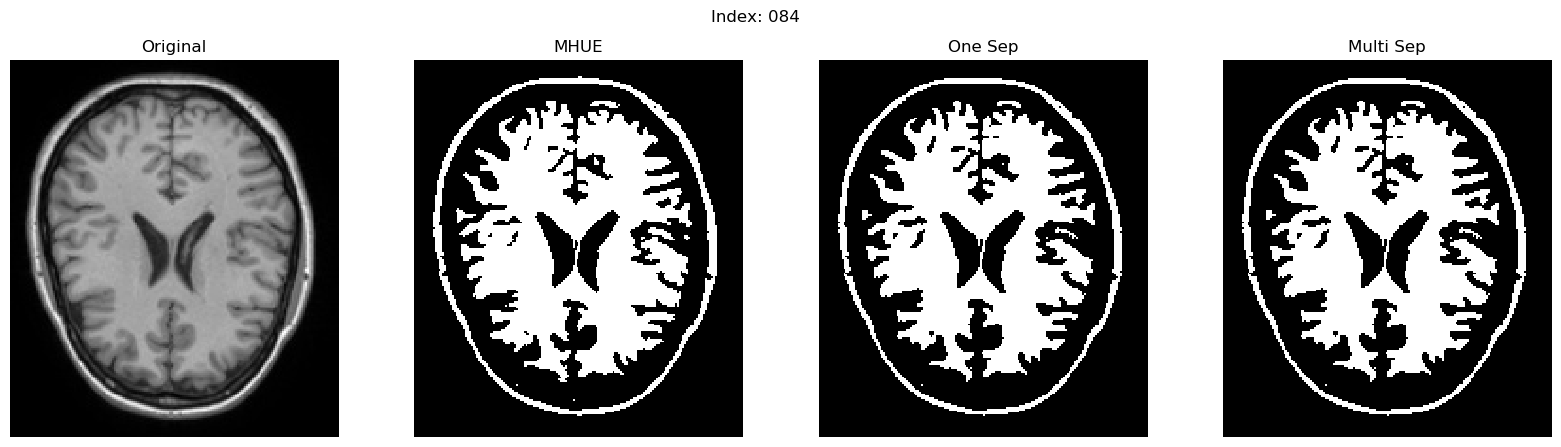

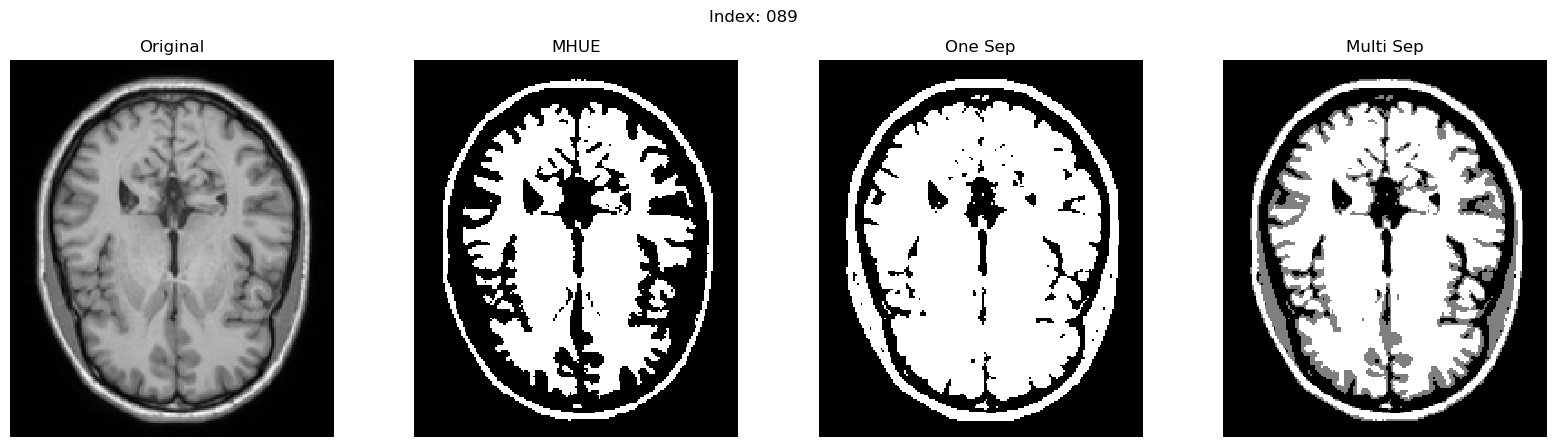

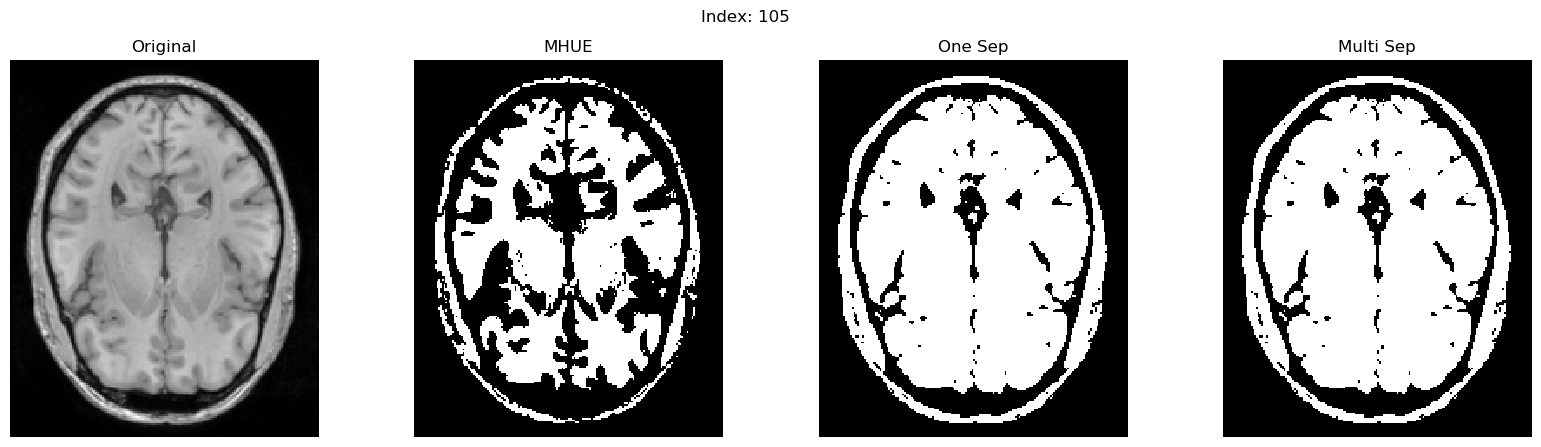

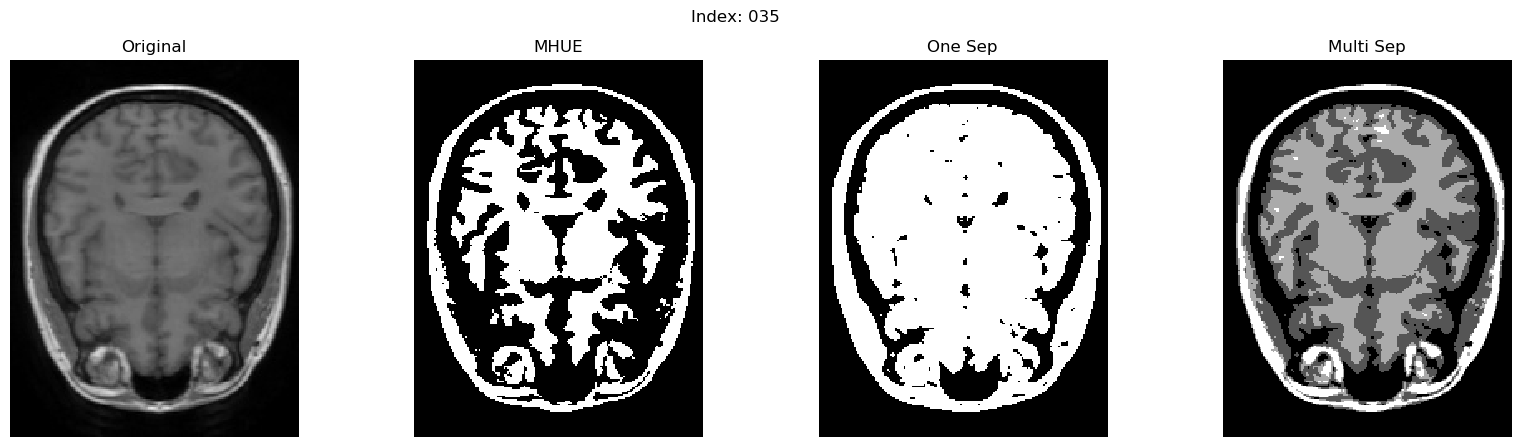

In [63]:
img_lst = param['img_org']
mhue_t = param['mhue_t']
region_t = param['region_t']

for idx,img in enumerate(img_lst):
    region_maxt = region_t[idx]
    mhue_mint = mhue_t[idx]
    plt.figure(figsize=(20,5))
    plt.suptitle('Index: {}'.format(idx_lst[idx]))
    plt.subplot(141)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(img,cmap='gray')
    
    plt.subplot(142)
    plt.axis('off')
    plt.title('MHUE')
    _,tmp = cv.threshold(img,mhue_mint,255,0)
    plt.imshow(tmp,cmap='gray')
    
    n_sep = region_maxt.size
    sep = np.zeros(shape=img.shape) * 255
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_maxt[n],255,0)
        if n==0:
            plt.subplot(143)
            plt.axis('off')
            plt.title('One Sep')
            plt.imshow(tmp,cmap='gray')
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(144)
    plt.axis('off')
    plt.title('Multi Sep')
    plt.imshow(sep,cmap='gray')

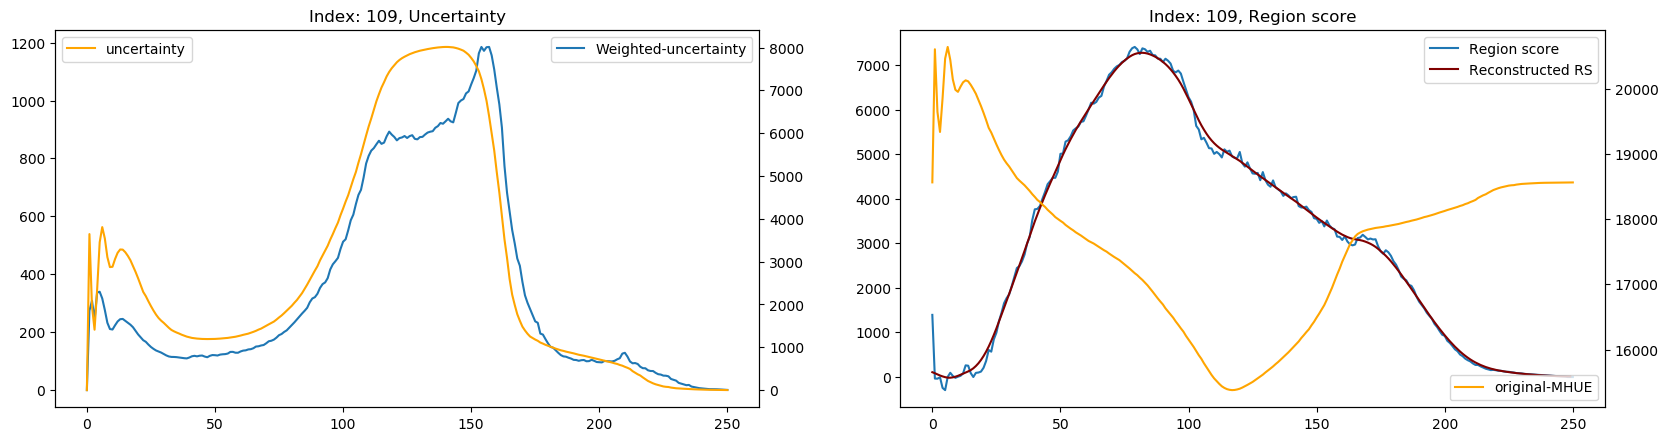

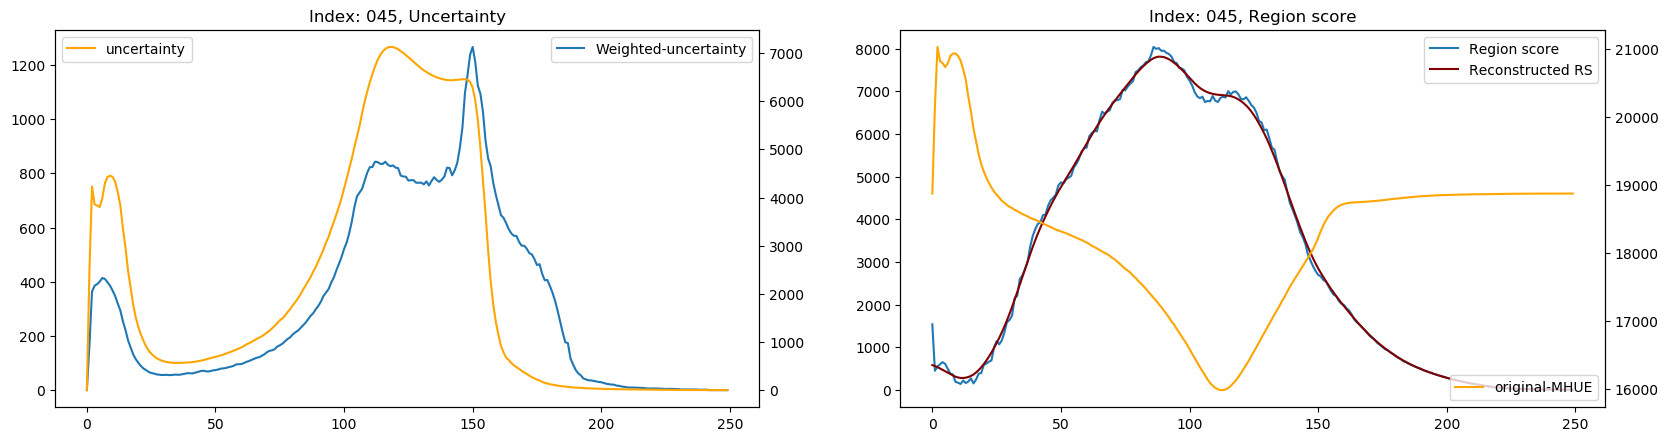

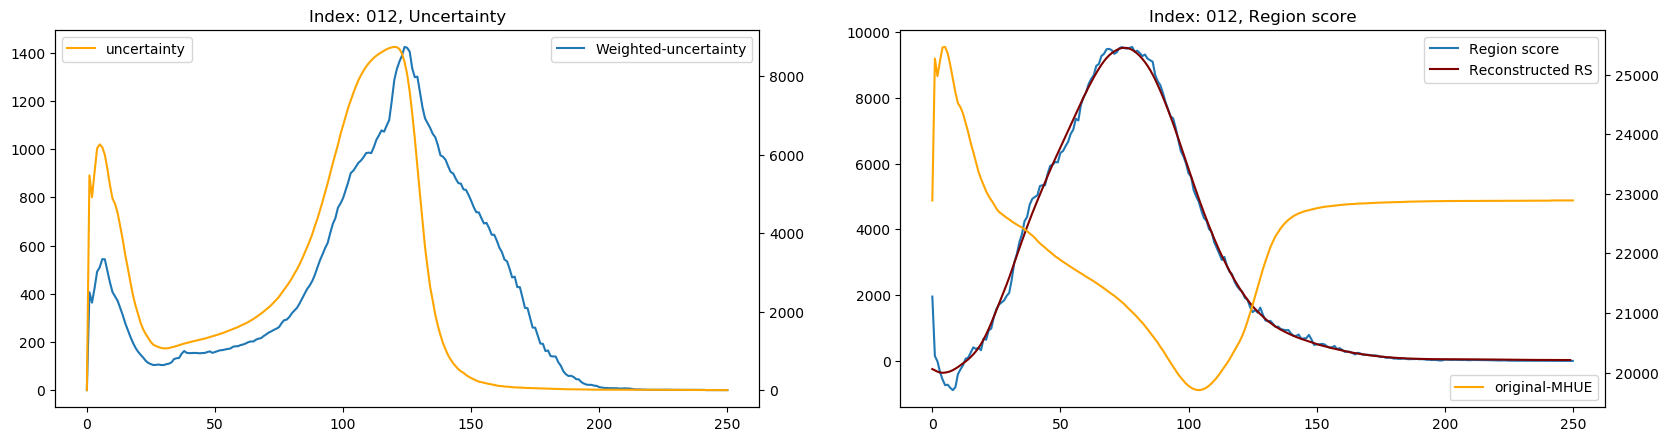

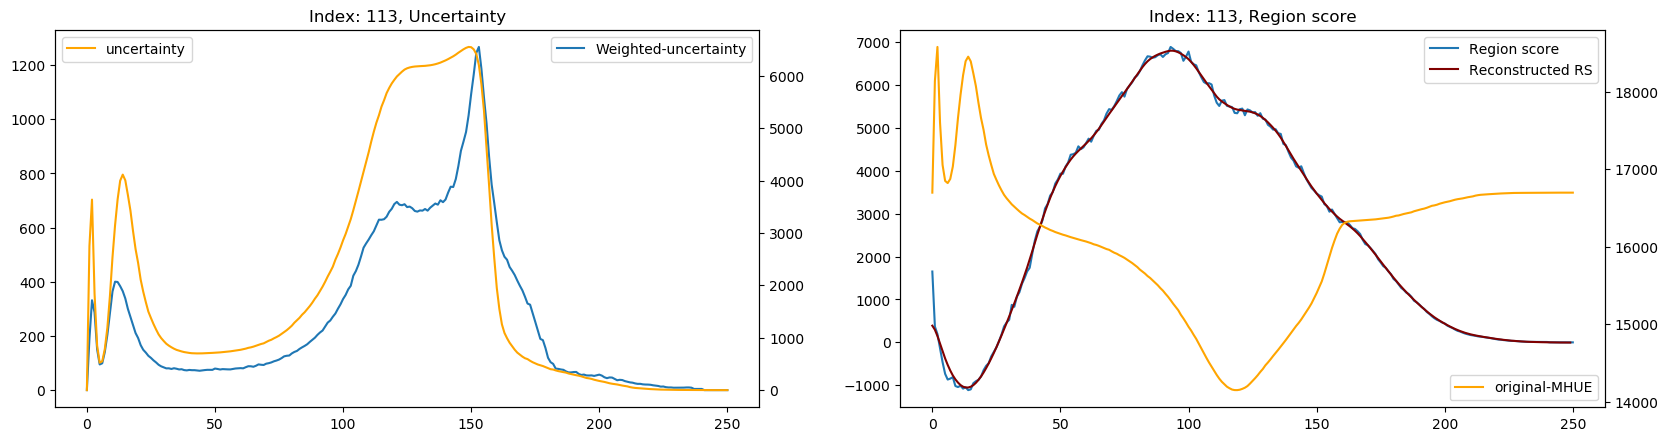

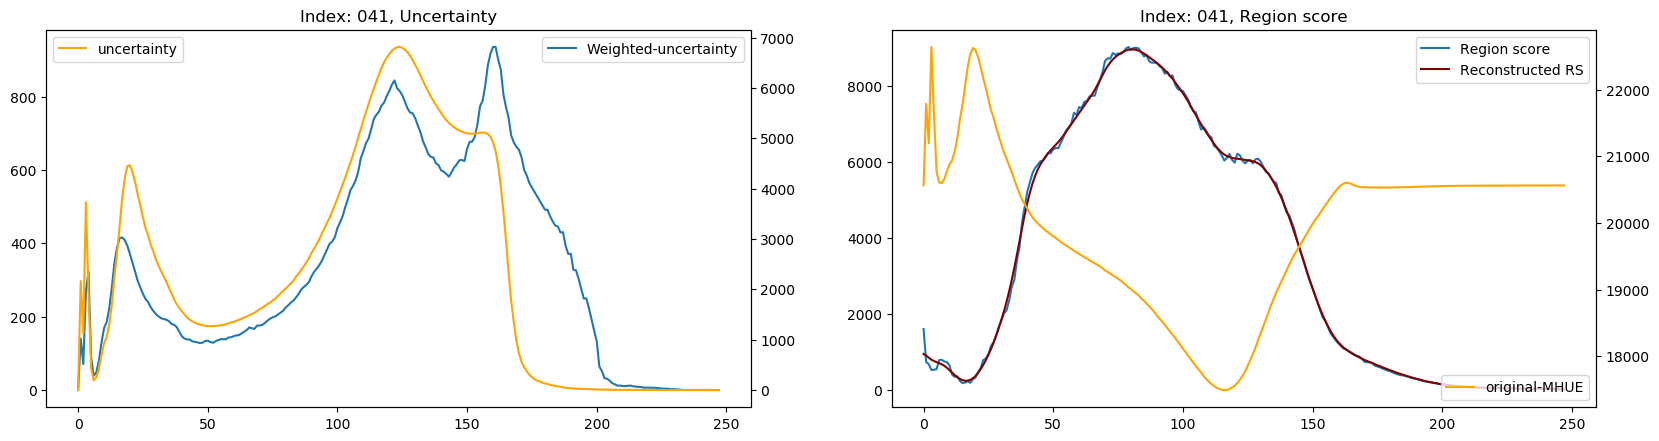

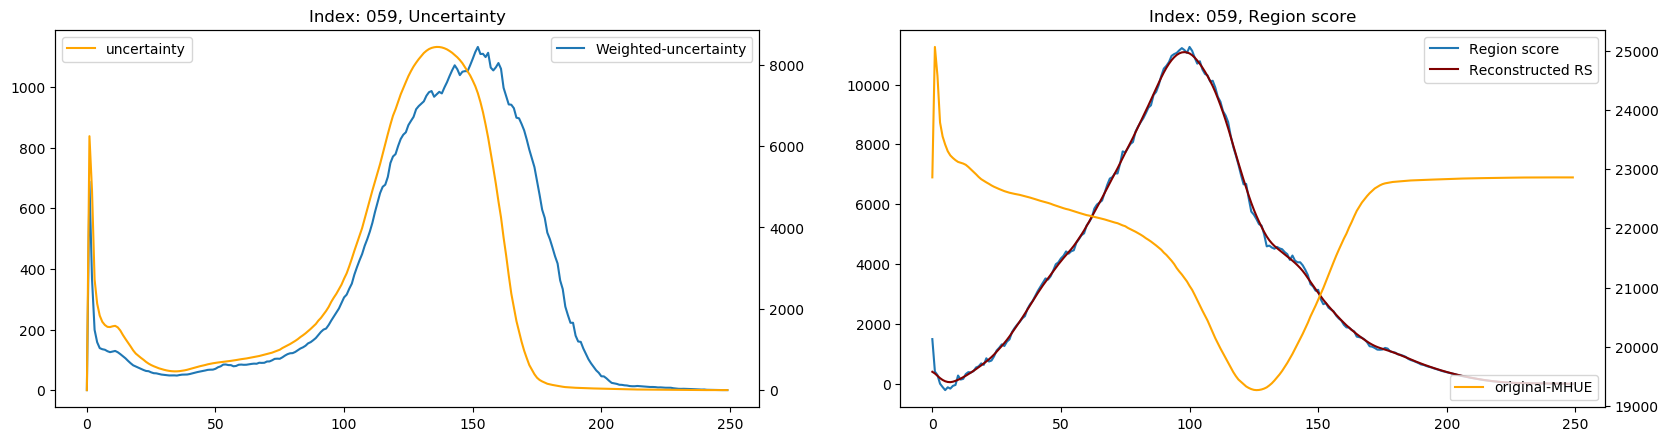

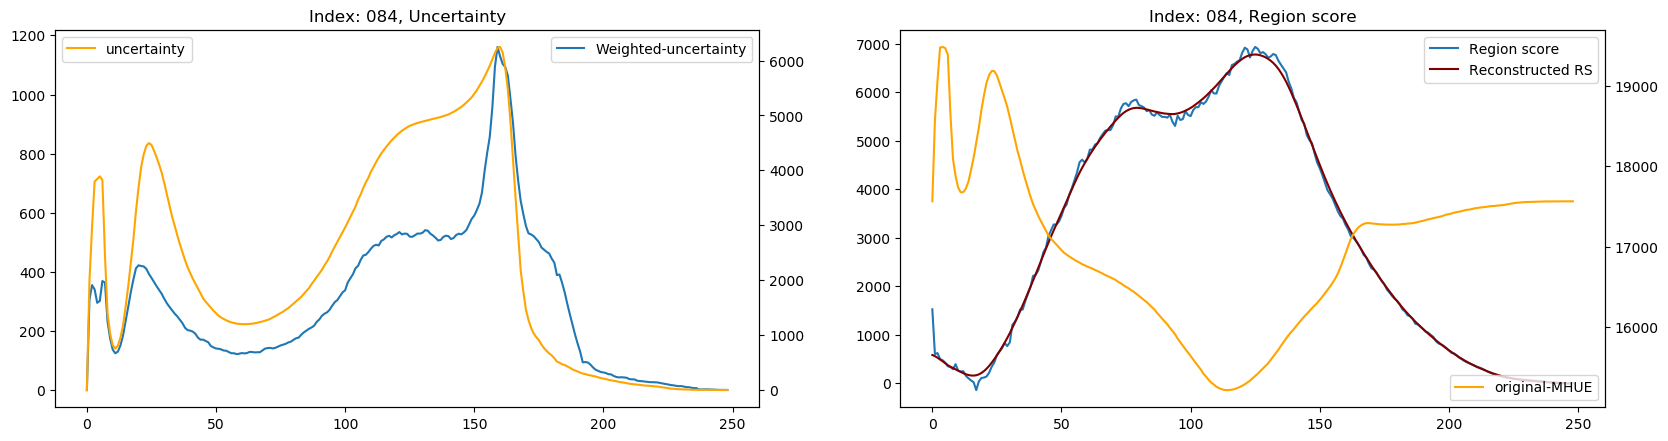

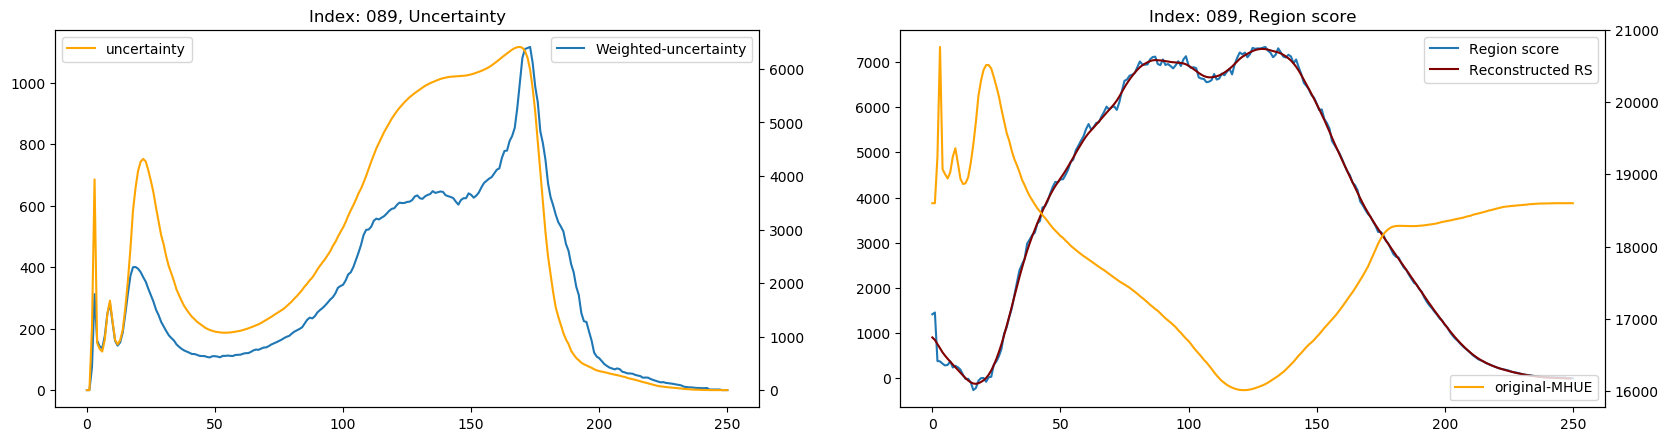

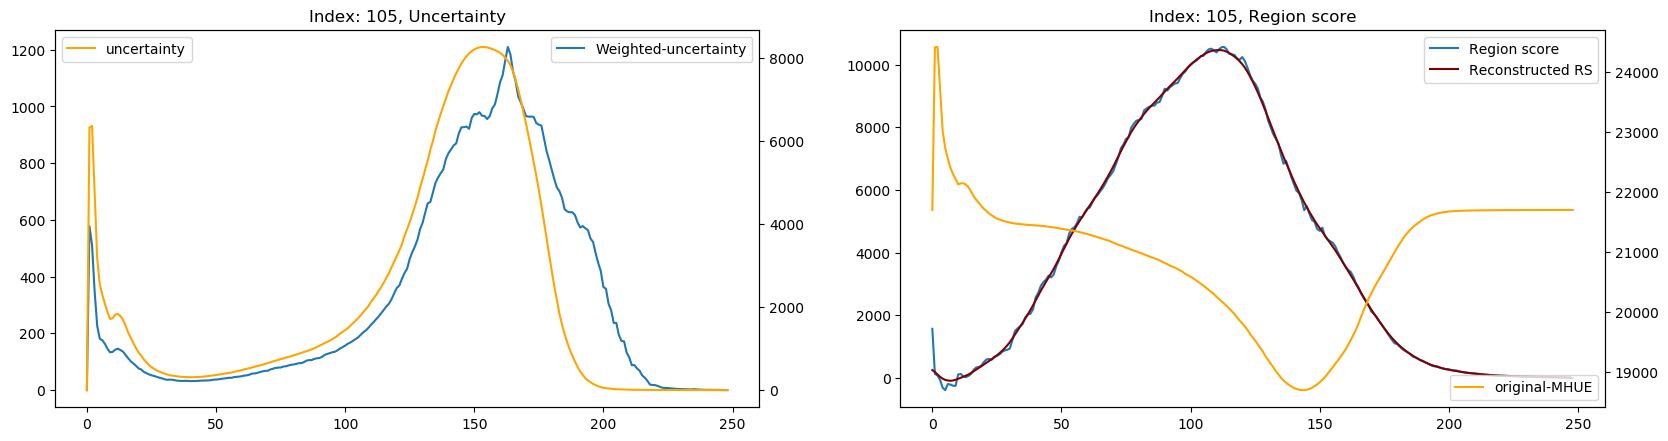

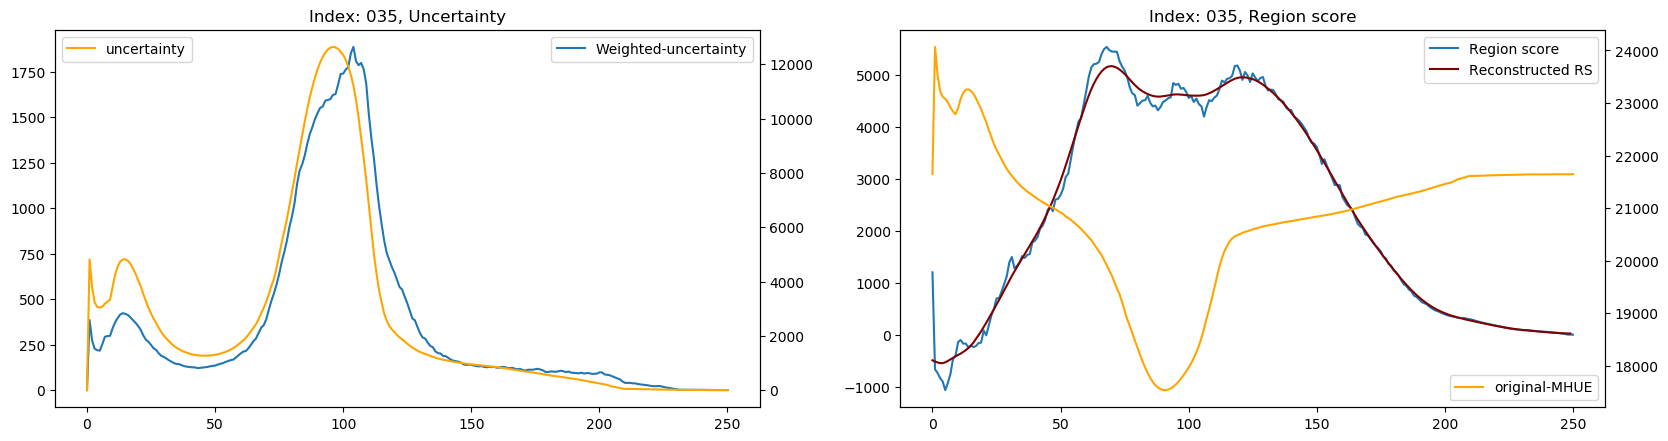

In [42]:
_uncertainty = param['uncertainty']
_img = param['img']
_stab = param['stab']
_mhue = param['mhue']
_uncertaintyw = param['uncertaintyw']
_region = param['region']
_r_recon = param['r_recon']

for i in range(len(_img)):
    _u = list(map(lambda x:np.sum(x),_uncertainty[i]))
    _uw = list(map(lambda x:np.sum(x),_uncertaintyw[i]))
    _e = list(map(lambda x:np.sum(x),_mhue[i]))
    _r = list(map(lambda x:np.sum(x),_region[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    ax1.plot(_uw,label='Weighted-uncertainty')
    ax1.legend(loc=1)
    ax2.plot(_u,color='orange',label='uncertainty')
    ax2.legend(loc=2)
    plt.title('Index: {}, Uncertainty'.format(img_idx[i]))
    
    ax3 = fig.add_subplot(122)
    ax4 = ax3.twinx()
    ax3.plot(_r,label='Region score')
    ax3.plot(_r_recon[i],color='maroon',label='Reconstructed RS')
    ax3.legend(loc='upper right')
    ax4.plot(_e,color='orange',label='original-MHUE')
    ax4.legend(loc=4)
    plt.title('Index: {}, Region score'.format(img_idx[i]))
    plt.show()
    plt.close()

In [37]:
def region_multi(img_idx,param,n_sep=3):
    img_lst = param['img']
    scharr_b_lst = param['scharr_b']
    stab_lst = param['stab']
    img_bdts_o = param['bdts_o']
    img_bdts_b = param['bdts_b']
    delta_lst = param['delta']
    
    region_t = []
    for idx,img in enumerate(img_lst):
        ts = []
        # mark the next minima
        next_minima = 0
        delta = delta_lst[idx]
        scharr = scharr_b_lst[idx]
        mask = np.ones(img.shape).astype(np.uint8)
              
        for sep in range(n_sep):
            img_mask = img * mask
            uncertaintyw = mhue.get_uncertainty(img_mask, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                                bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=31,sigma=0.5)
            # new region score
            scharr_mask = scharr.copy()
            for i in range(len(scharr)):
                scharr_mask[i] = scharr[i] * mask
                
            region_i = region.get_score(img_mask,uncertaintyw,scharr_mask,kernel_size=5,bounding=True)
            r_recon = region.vmd_extract(region_i,var_min=0.01)
            # some weired case
            if len(r_recon) <= 1:
                break
            # very first maxima
            local_max = argrelmax(r_recon,order=delta//2)[0]
            
            # take the local maxima if it's larger than the former valley value
            flag = False
            if len(local_max) >= 1:
                for t in local_max:
                    if t > next_minima:
                        local_max = t
                        flag = True
                        break
            # jump out if not maxima is found
            elif len(local_max) == 0:
                break
            
            # jump out if the maxima is smaller than the former valley value
            if not flag:
                break
            
            best_region_t = local_max + np.min(img) + 2
            ts.append(best_region_t)
            _,mask = cv.threshold(img,best_region_t,1,0)
            
            # find the next minima
            local_min = argrelmin(r_recon,order=delta//2)[0]  + np.min(img) + 2
            
            # Find the next valley value larger the current best region t
            if np.max(local_min) < local_max:
                break
            else:
                for t in local_min:
                    if t > local_max:
                        next_minima = t
                        break

        print('Index: {}, Region score threshold: {}.'.format(img_idx[idx], ts))
        region_t.append(ts)
    param['region_multi_t'] = region_t
    return param

In [38]:
param2 = region_multi(idx_lst,param)

Index: 109, Region score threshold: [83].
Index: 045, Region score threshold: [91].
Index: 012, Region score threshold: [77].
Index: 113, Region score threshold: [95].
Index: 041, Region score threshold: [83].
Index: 059, Region score threshold: [100].
Index: 084, Region score threshold: [81, 106, 136].
Index: 089, Region score threshold: [89, 115, 146].
Index: 105, Region score threshold: [113].
Index: 035, Region score threshold: [71, 105, 145].


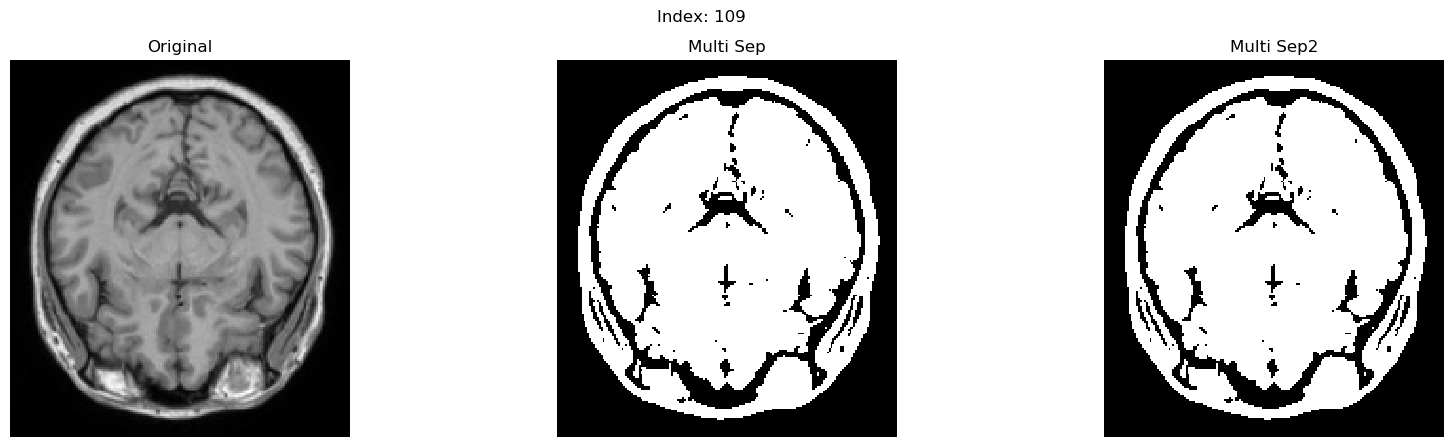

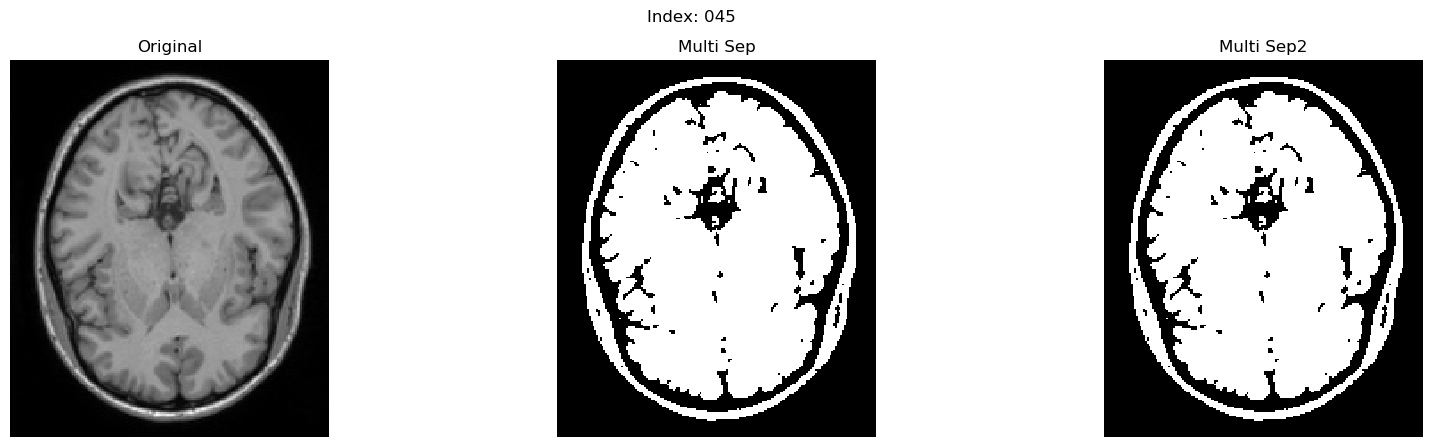

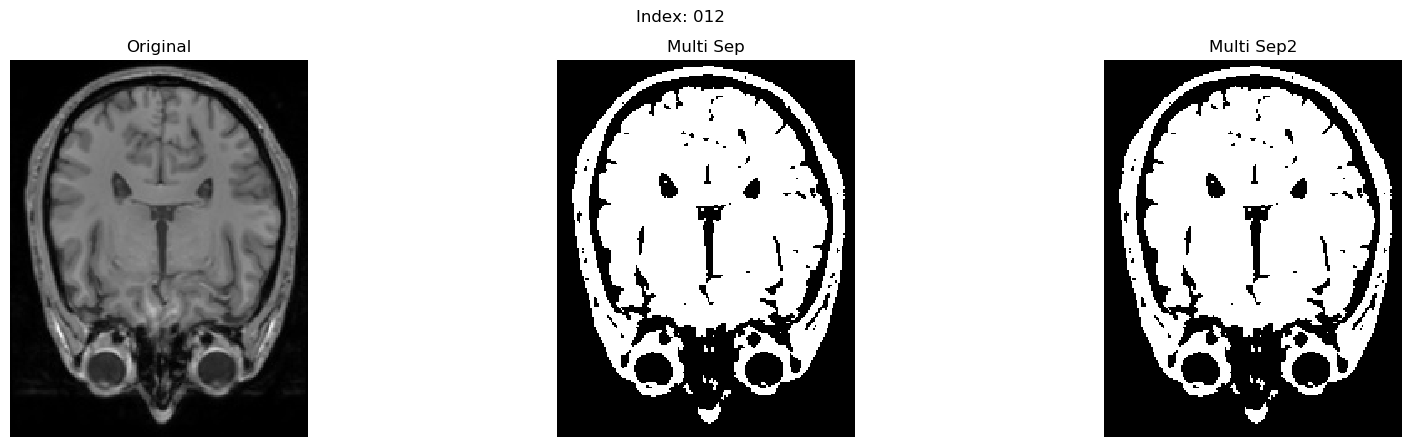

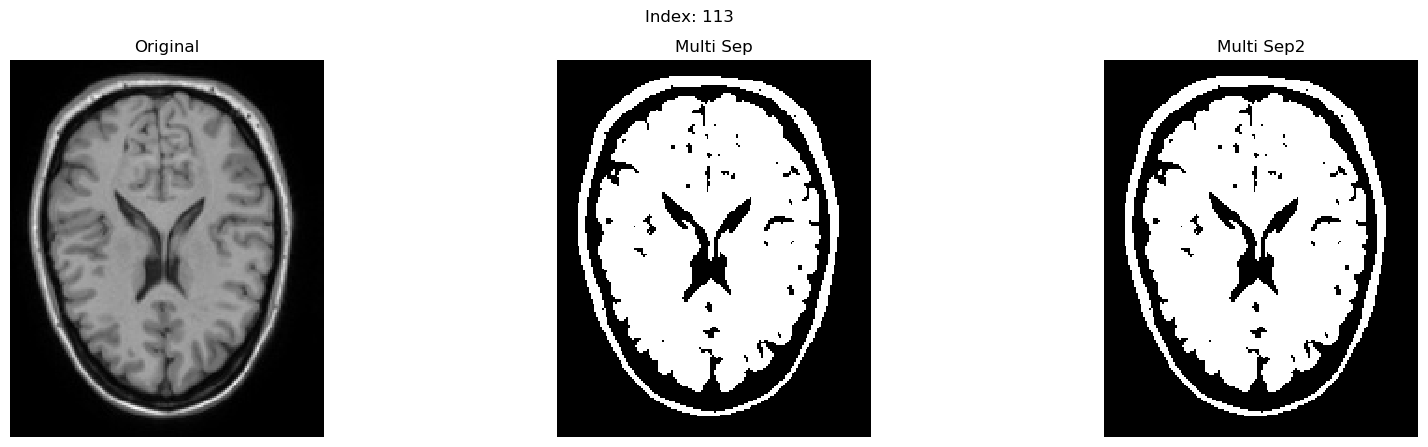

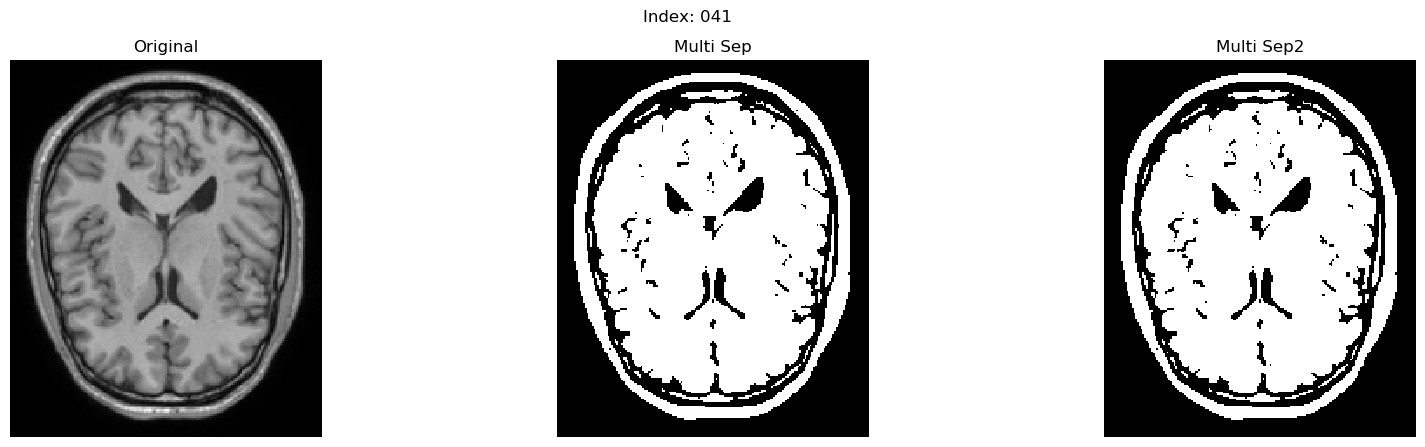

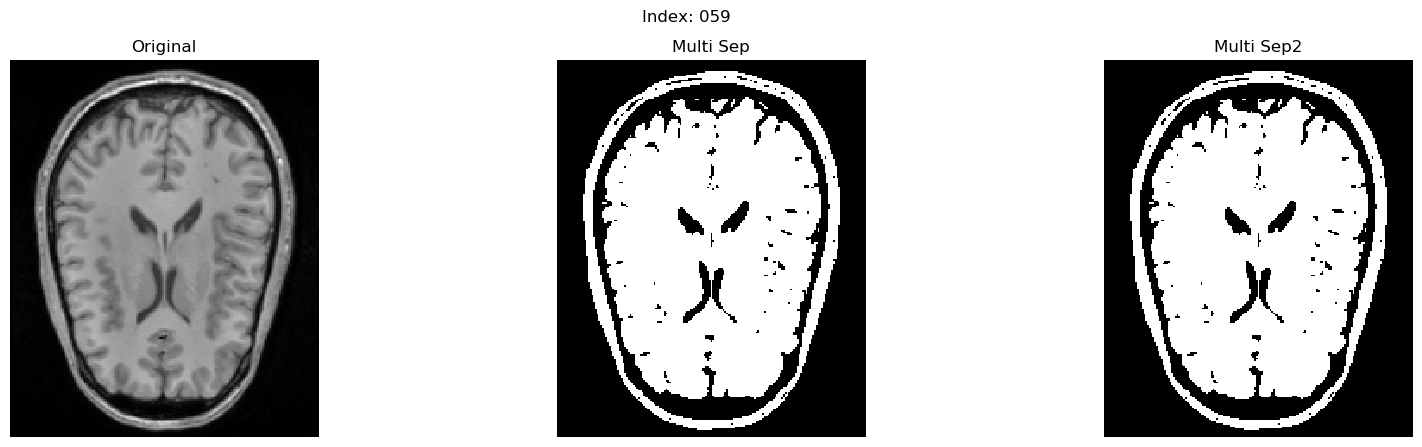

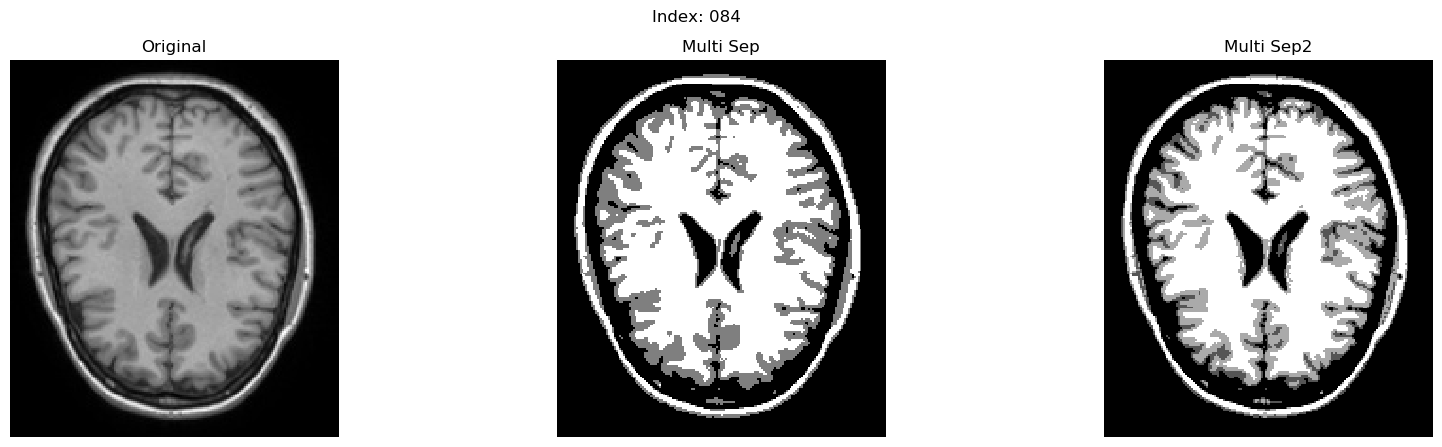

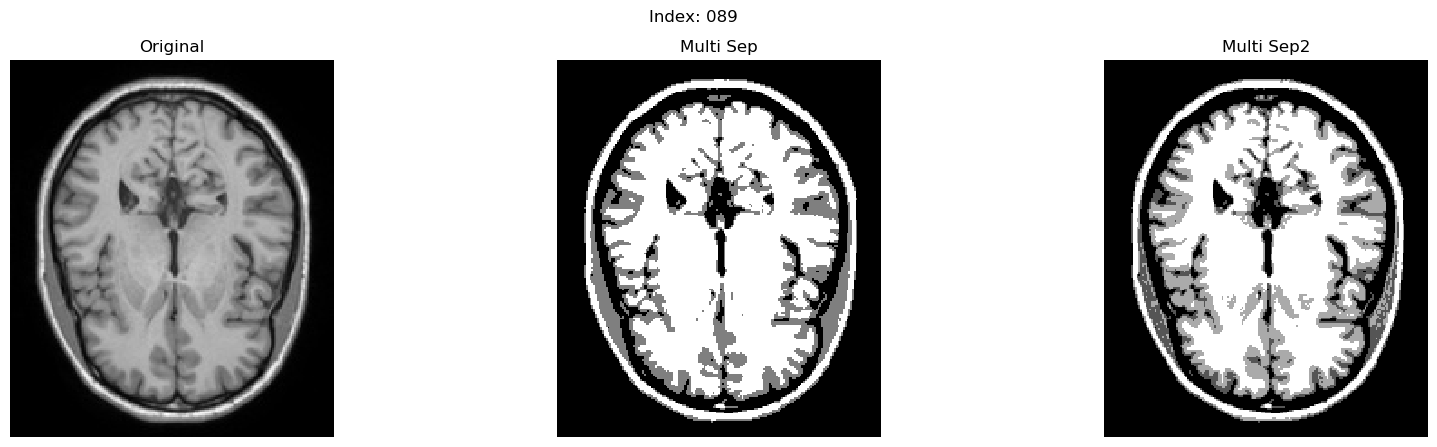

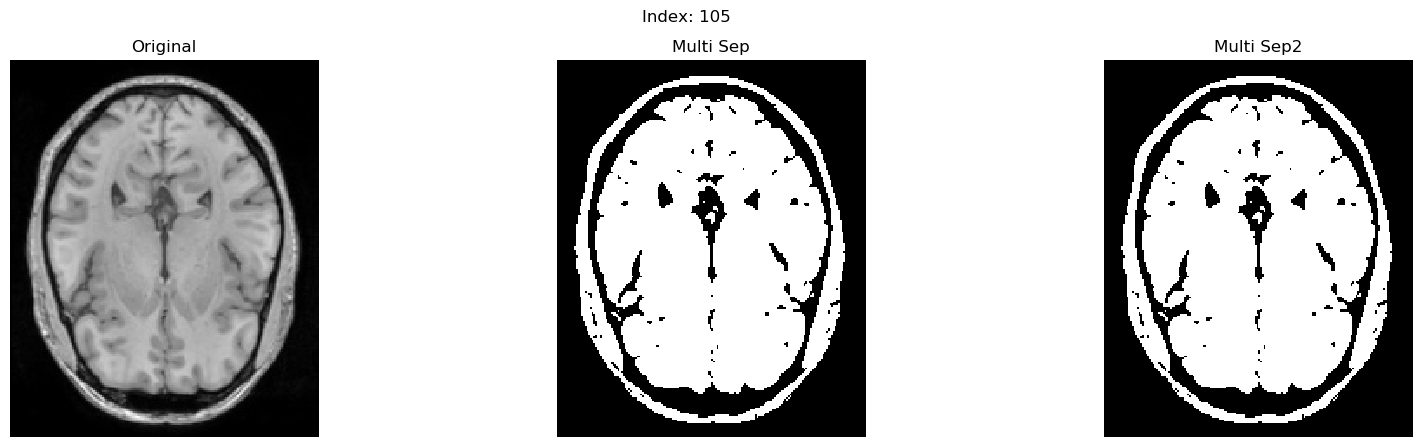

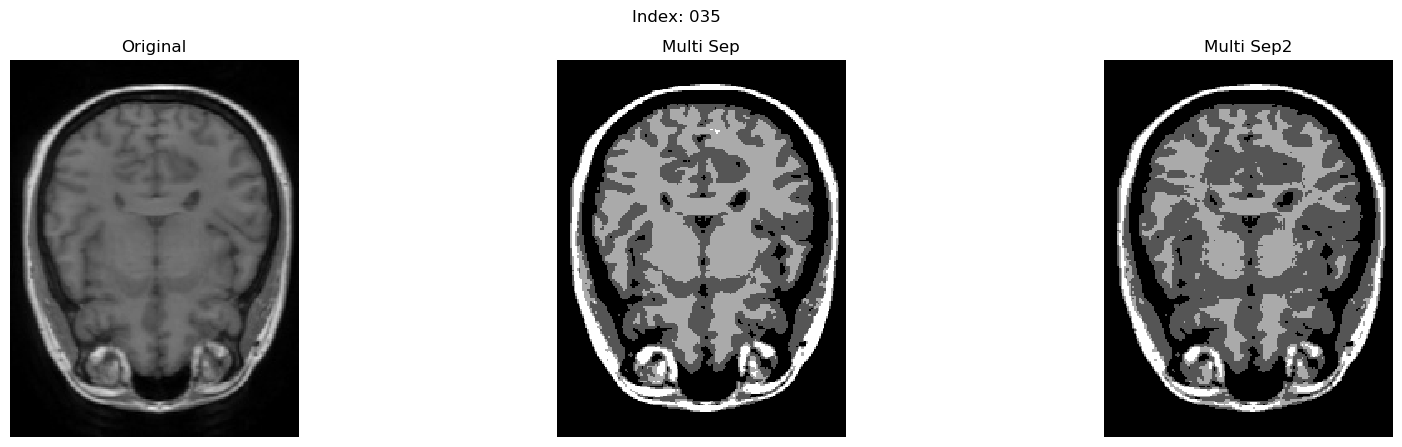

In [41]:
img_idx = idx_lst.copy()
img_lst = param2['img_org']
mhue_t = param2['mhue_t']
region_t = param2['region_t']
region_multi_t = param2['region_multi_t']

for idx,img in enumerate(img_lst):
    region_maxt = region_t[idx]
    mhue_mint = mhue_t[idx]
    region_multi_maxt = region_multi_t[idx]
    plt.figure(figsize=(20,5))
    plt.suptitle('Index: {}'.format(img_idx[idx]))
    plt.subplot(131)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(img,cmap='gray')
    
    n_sep = region_maxt.size
    sep = np.zeros(shape=img.shape)
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_maxt[n],255,0)
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(132)
    plt.axis('off')
    plt.title('Multi Sep')
    plt.imshow(sep,cmap='gray')
    
    
    n_sep = len(region_multi_maxt)
    sep = np.zeros(shape=img.shape)
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_multi_maxt[n],255,0)
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(133)
    plt.axis('off')
    plt.title('Multi Sep2')
    plt.imshow(sep,cmap='gray')
    

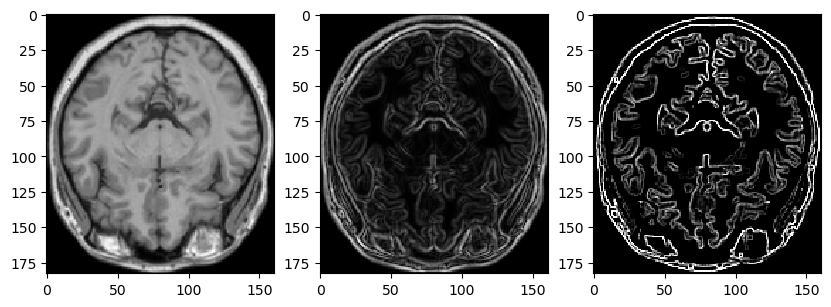

In [73]:
img_lst = param['img']
img = img_lst[0]
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(homogeneity.get_scharr(img))
plt.subplot(133)
scharr_lst = param['scharr_b']
plt.imshow(scharr_lst[0][100])

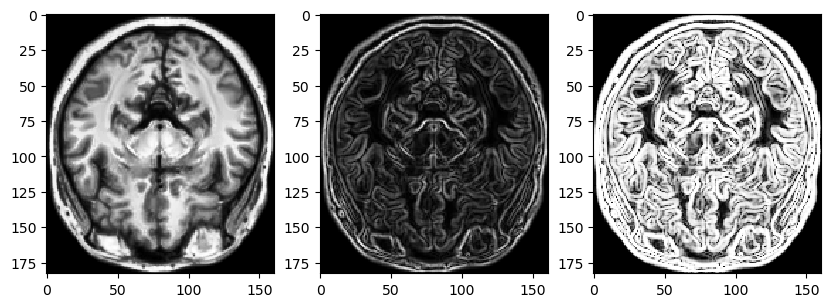

In [101]:
img = img_lst[0]
img_equalize = cv.fastNlMeansDenoising(img)
clahe=cv.createCLAHE(7,(3,3))
img_equalize = clahe.apply(img_equalize)
# img_equalize = cv.equalizeHist(img_equalize)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img_equalize)
plt.subplot(132)
equal_scharr = homogeneity.get_scharr(img_equalize)
plt.imshow(equal_scharr)
plt.subplot(133)
equal_scharr_n = homogeneity.rank_normalize(equal_scharr)
plt.imshow(equal_scharr_n)

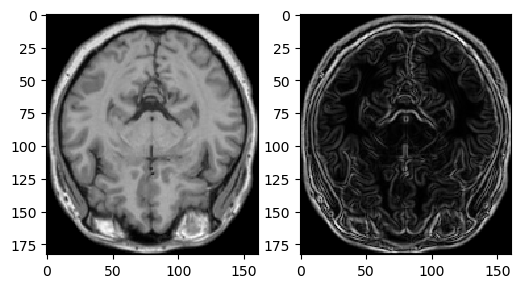

In [102]:
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(homogeneity.get_scharr(img2))